# US Medical Insurance Cost

In this project, a **CSV** file with medical insurance costs will be investigated using Python fundamentals and ML algorithims. My goal is to find an effective model to predict the insurance costs by using various attributes of isurance policyholders. (so that I can save my insurance cost!!)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
import math

# 1. Dataset 

In [37]:
#Load data into a dataframe
insurance = pd.read_csv('insurance.csv')

In [38]:
#check the head of dataframe
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


6 data fields about insurance policyholders as below 
* age: policyholder's age / integer variable
* sex: policyholder's sex / string variable
* bmi: policyholder's Body Mass Index / float variable - BMI is used for defining a person's weight category (underweight, normal weight, overweight, obese) 
* children: the number of children a policyholder has / integer variable
* smoker: policyholder smoking or not / string variable
* region: a region where a policyholder lives / string variable 
* charges: amount of charges a policyholder pays / float variable

# 2. Converting categorical variables into numerical variables 

In [39]:
#Select my predictos
x = insurance [['age', 'sex', 'bmi', 'children', 'smoker', 'region']]
#Select my response
y= insurance['charges']

As shown in the data field introduction, the following columns (sex,smoker,region) contain string variables. <br> Mulitple linear regression model is algebraic where all of your inputs have to be numeric. Thus, I will transform these categorical variables into numerical variables. 


transform  [sex,smoker]  into binary variable

1. sex <br>
0: male 1:female

2. smoker <br> 0: no 1: yes 

In [40]:
x['sex_n'] = x['sex'].map({'male':0,'female':1})
x['smoker_n'] = x['smoker'].map({'yes':1,'no':0})

3. region

In [41]:
#Checking the number of levels for the column:region
x.region.value_counts()

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

There are 4 levels for 'region'. One can think of assigning numerical labels to these regions, but these regions don't have intrinsic ordering between them (categorical variables). For example. we are not able to claim that northwest region (value of 3) deserve 3x bigger number than the southwest region (value of 1) with no valid reason.

Thus, I have to create dummy variables. I applied one hot encoding scheme with which 4 bianry variables will take the place of the original categorical variable

The first step is to create a column 'region_label' which contains numeric representations of the original column 'region' by using LabelEncoder

In [42]:
#tranform and map regions 
region_le = LabelEncoder()
region_label = region_le.fit_transform(x.region)
x['region_label']= region_label

In [43]:
x['region_label']

0       3
1       2
2       2
3       1
4       1
       ..
1333    1
1334    0
1335    2
1336    3
1337    1
Name: region_label, Length: 1338, dtype: int64

The second step is to create 4 dummy variables (binary variables) by using OneHotEncoder()

In [44]:
#encode region labels using one-hot encoding scheme
region_hot = OneHotEncoder()
region_feature_arr = region_hot.fit_transform (x[['region_label']]).toarray()
region_feature_labels=list(region_le.classes_)
region_features = pd.DataFrame(region_feature_arr,columns=region_feature_labels)
region_features

,northeast,northwest,southeast,southwest
0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
1333,0.0,1.0,0.0,0.0
1334,1.0,0.0,0.0,0.0
1335,0.0,0.0,1.0,0.0
1336,0.0,0.0,0.0,1.0


In [45]:
x = pd.concat([x,region_features],axis=1)
x

,age,sex,bmi,children,smoker,region,sex_n,smoker_n,region_label,northeast,northwest,southeast,southwest
0,19,female,27.900,0,yes,southwest,1,1,3,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,0,0,2,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,0,0,2,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,0,0,1,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,1,0,0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1,0,2,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,1,0,3,0.0,0.0,0.0,1.0


I'm done with encoding my categorical variables!! I will re-select my predictors with numerical variables only! 

One of the dummy variables will be left behind. You can find the explanation why we left 1 dummy variable behind here: http://www.feat.engineering/creating-dummy-variables-for-unordered-categories.html

In [46]:
x_lean= x[['age', 'sex_n', 'bmi', 'children', 'smoker_n', 'southeast','northwest','southwest']]
x_lean

,age,sex_n,bmi,children,smoker_n,southeast,northwest,southwest
0,19,1,27.900,0,1,0.0,0.0,1.0
1,18,0,33.770,1,0,1.0,0.0,0.0
2,28,0,33.000,3,0,1.0,0.0,0.0
3,33,0,22.705,0,0,0.0,1.0,0.0
4,32,0,28.880,0,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1333,50,0,30.970,3,0,0.0,1.0,0.0
1334,18,1,31.920,0,0,0.0,0.0,0.0
1335,18,1,36.850,0,0,1.0,0.0,0.0
1336,21,1,25.800,0,0,0.0,0.0,1.0


# 3. Exploring predictors - Simple Linear Regression

I will explore each predictor to uncover any interesting characteristics.

##  a. age 
First, I would like to find a correlation between age and charges. 

p-value:1.561377623951052e-13 is less than .05. We can conclude that there's some relationship between age and charges


Text(20, 22000, 'P value = 1.561377623951052e-13\nR squared = 0.7056733914929724')

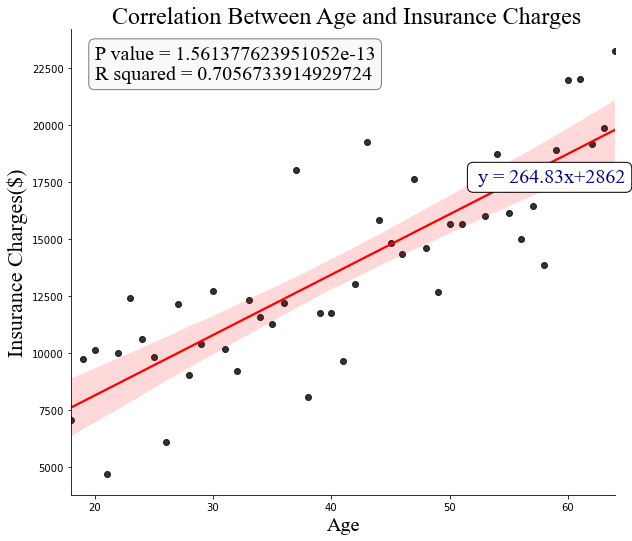

In [47]:
#average Charges by age
avg_by_age = insurance.groupby('age').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_age.age,avg_by_age.charges)
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'

#Hypothesis test on the coefficient
if p_value <.05:
    print("p-value:{} is less than .05. We can conclude that there's some relationship between age and charges".format(p_value))
else:
    print("p-value:{} is greater than .05. We can't conclude that there's some relationship between age and charges".format(p_value))
  

#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)


#plot age vs charges
graph_age = sns.lmplot(data = avg_by_age, x = 'age', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws = {'color':'black'})
plt.xlabel('Age',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Age and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(52,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box)
plt.text(20,22000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)


<b>Conclusion: <br>The above graph clearly indicates that there is a positive correction and the p-value is less than .05. Thus, this variable is statistically significant at 5% level. R_squared is also pretty high around 71%. This means that 71% of the variability in insurance charges can be explained by age: the older you are the more you pay for the insurance. The linear regression equation suggests that you get 1 year older, the charge will be increased by $264.83.  

## b. bmi 
BMI stands for Body Mass Index. This variable is expected to have a high correlation with insurance charages. Let's see if that's the case!

p-value:2.1666931918269805e-10 is less than .05. We can conclude that there's some relationship between BMI and charges


Text(15, 59000, 'P value = 2.1666931918269805e-10\nR squared = 0.07123127111893408')

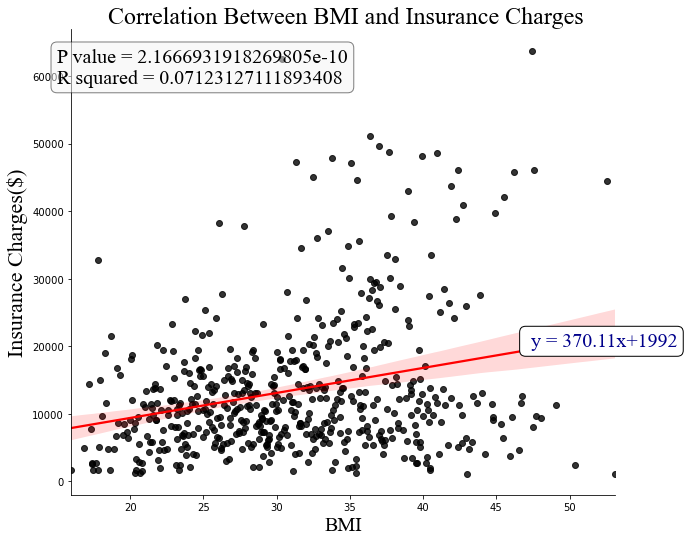

In [48]:
#average Charges by bmi
avg_by_bmi = insurance.groupby('bmi').charges.mean().reset_index()

#linear regression equation bewteen age and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(avg_by_bmi.bmi,avg_by_bmi.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("p-value:{} is less than .05. We can conclude that there's some relationship between BMI and charges".format(p_value))
else:
    print("p-value:{} is greater than .05. We can't conclude that there's some relationship between BMI and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_age = sns.lmplot(data = avg_by_bmi, x = 'bmi', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('BMI',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between BMI and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(47,20000,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box)
plt.text(15,59000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: <br> 
The above graph shows that there is a positive correction between BMI and insurance charge and the p-value is less than .05 so this variable is statistically significant at 5% level. However, $r^2$ is only 7%. This means that only 7% of the variation in insurance charges is explained by BMI, which suggeat that there are many other factors that might be affecting insurance charges. This is interesting because I  thought that BMI would be a great indicator of his/her wellness, which would be highly associated with insurance costs. This is not the case within this dataset. 

## c. sex 
The sex variable is a qualitative predictor with two levels.I will plot a side-by-side box plot and compare their means to see if there's a significant difference. 

<AxesSubplot:xlabel='sex', ylabel='charges'>

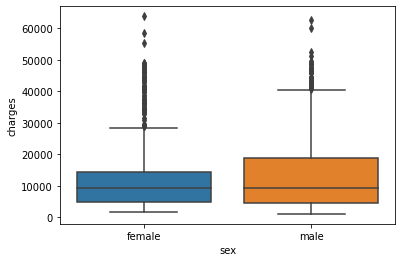

In [49]:
sns.boxplot(data = insurance, x = 'sex', y ='charges')

In [50]:
#find average charges of male and female
mean_male = np.mean(insurance.charges[insurance.sex == 'male'])
mean_female = np.mean(insurance.charges[insurance.sex == 'female'])

In [51]:
print('The average insurance charge for male is {} and the average insurance charge for female is {}'.format(mean_male,mean_female))

The average insurance charge for male is 13956.751177721886 and the average insurance charge for female is 12569.57884383534


In [52]:
#concatenate predictors with charge 
x_lean_charge = pd.concat([x,y],axis=1)
x_lean_charge

,age,sex,bmi,children,smoker,region,sex_n,smoker_n,region_label,northeast,northwest,southeast,southwest,charges
0,19,female,27.900,0,yes,southwest,1,1,3,0.0,0.0,0.0,1.0,16884.92400
1,18,male,33.770,1,no,southeast,0,0,2,0.0,0.0,1.0,0.0,1725.55230
2,28,male,33.000,3,no,southeast,0,0,2,0.0,0.0,1.0,0.0,4449.46200
3,33,male,22.705,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0,21984.47061
4,32,male,28.880,0,no,northwest,0,0,1,0.0,1.0,0.0,0.0,3866.85520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,0,0,1,0.0,1.0,0.0,0.0,10600.54830
1334,18,female,31.920,0,no,northeast,1,0,0,1.0,0.0,0.0,0.0,2205.98080
1335,18,female,36.850,0,no,southeast,1,0,2,0.0,0.0,1.0,0.0,1629.83350
1336,21,female,25.800,0,no,southwest,1,0,3,0.0,0.0,0.0,1.0,2007.94500


In [68]:
#linear regression equation bewteen sex and charges
slope, intercept, r_value2,p_value,std_err = stats.linregress(x_lean_charge.sex_n,x_lean_charge.charges)

#print r_squared_value
print('r_squred value is {}'.format(r_value2**2))

#Hypothesis test on the coefficient
if p_value <.05:
    print("p-value:{} is less than .05. We can conclude that there's some relationship between sex and charges".format(p_value))
else:
    print("p-value:{} is greater than .05. We can't conclude that there's some relationship between sex and charges".format(p_value))

r_squred value is 0.0032823803913607508
p-value:0.036132721005929666 is less than .05. We can conclude that there's some relationship between sex and charges


<b>Conclusion: <br> 
Looking at the plot, there is a lot of overlap between the boxes. Thus, we can be confident that there is not much difference between the insurance charges of the two groups. In addtion, $r^2$ is only 3%, further confirming that there's not much of association between sex and insurance charges. 

## d. children

0.012852128520136412 is less than .05. We can conclude that there's some relationship between children and charges


Text(0.2, 58000, 'P value = 0.012852128520136412\nR squared = 0.004623758854459131')

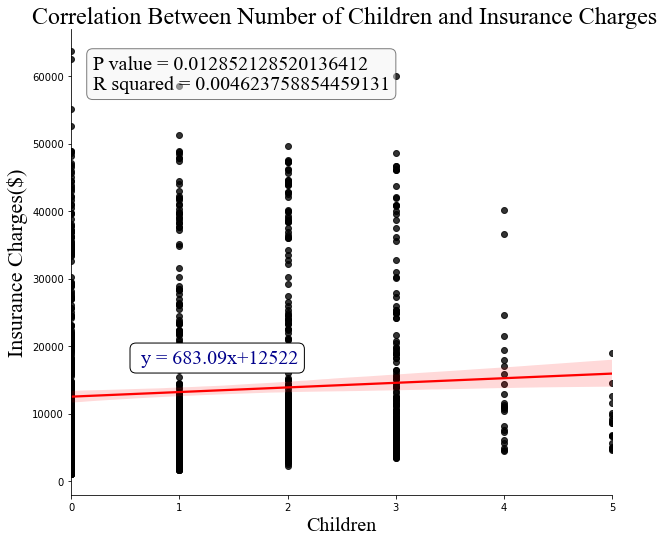

In [54]:
#linear regression equation bewteen children and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(x_lean_charge.children,x_lean_charge.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between children and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between children and charges".format(p_value))
    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

#Textbox properties
box = dict(boxstyle='round', facecolor='white', alpha=1)
box2 = dict(boxstyle='round', facecolor='whitesmoke', alpha=.5)

#plot age vs charges
graph_sex = sns.lmplot(data = x_lean_charge, x = 'children', y='charges',line_kws = {'color':'red'},height=7,aspect = 1.2,scatter_kws= {'color':'black'})
plt.xlabel('Children',fontsize =20,fontname = 'Times New Roman')
plt.ylabel('Insurance Charges($)',fontsize = 22,fontname = 'Times New Roman')
plt.title(" Correlation Between Number of Children and Insurance Charges",fontsize= 24,fontname = 'Times New Roman')
plt.text(.6,17500,line_equation,fontsize=20,color='darkblue',fontname = 'Times New Roman',bbox=box)
plt.text(0.2,58000,r_p_value,fontsize=20,color='black',fontname = 'Times New Roman',bbox=box2)

<b>Conclusion: <br>We can reach a similiar conclusion as sex. It is statistcally significant, but the r_sqaured is only 0.4% 

## e. Smoker
Since 'smoker' is also binary categorical variable, I will use a boxplot and compare the average charges between smoker and non-smoker groups. 

<AxesSubplot:xlabel='smoker', ylabel='charges'>

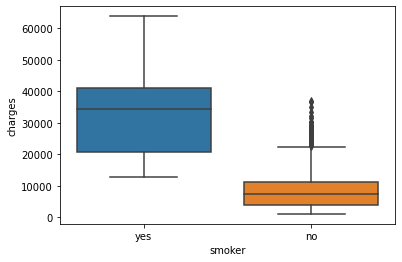

In [55]:
sns.boxplot(data = insurance, x = 'smoker', y ='charges')

In [56]:
#find average charges of smokers and non-smokers
mean_smoker = np.mean(insurance.charges[insurance.smoker == 'yes'])
mean_non_smoker = np.mean(insurance.charges[insurance.smoker == 'no'])

In [57]:
print('The average insurance charge for smokers is {} and the average insurance charge for non-smokers is {}'.format(mean_smoker,mean_non_smoker))

The average insurance charge for smokers is 32050.23183153285 and the average insurance charge for non-smokers is 8434.268297856199


In [58]:
#linear regression equation bewteen children and charges
slope, intercept, r_value,p_value,std_err = stats.linregress(x_lean_charge.smoker_n,x_lean_charge.charges)


#Hypothesis test on the coefficient
if p_value <.05:
    print("{} is less than .05. We can conclude that there's some relationship between smoker and charges".format(p_value))
else:
    print("{} is greater than .05. We can't conclude that there's some relationship between smoker and charges".format(p_value))

    
#text in textbox 
line_equation = f' y = {slope:.2f}x+{intercept:.0f}'
r_p_value = f"""P value = {p_value}
R squared = {r_value**2}"""

print("Linear equation between smoker and insurance charges:{}".format(line_equation))



8.271435842179102e-283 is less than .05. We can conclude that there's some relationship between smoker and charges
Linear equation between smoker and insurance charges: y = 23615.96x+8434


<b>Conclusion: <br> Look at the plot! The boxes don't overlap at all. The middel 50% are significantly different for the two groups. If you are a smoker, you have to pay $23615 more!! Quit smoking today to be finacially free!
 

## <b> Chapter Summary
age, smoker = high effect on insurance charges <br>
sex, bmi, children = low effect on insurance charges<br>

Even though the bottom 3 variables have low effect on insurance charges, I will use them for my multiple linear regression since they are at least statistically significant. 
    

# 4. Statistical Method - Multiple Regression Model

<AxesSubplot:>

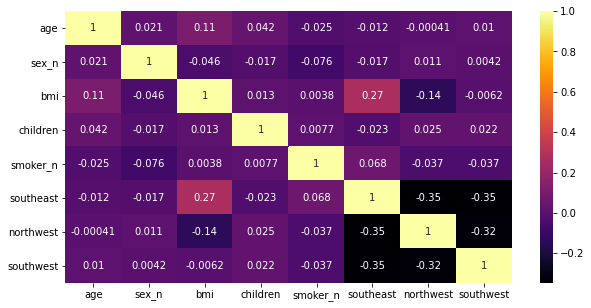

In [59]:
#Correlations between my predictors 
f,ax = plt.subplots(figsize= (10,5))
corr = x_lean.corr()
sns.heatmap(corr, cmap = 'inferno',annot = True)


I check if there's any multicolliearity. None of predictors have high correlation among themselves

Before building a model, I will split the data into the training set and the test set. 80% of the data were allocated to the training set

In [60]:
#split the data into training and testing
x_train,x_test,y_train,y_test = train_test_split(x_lean,y,train_size=.8,random_state=5)

#verifying the training and testing data
print(x_train.shape)
print(x_test.shape)

(1070, 8)
(268, 8)


Creating a multiple linear regression model and fit it to my x_train and y_train.

In [61]:
#create an object 
mlr = LinearRegression()

#fit the data
mlr.fit(x_train,y_train)

LinearRegression()

In [62]:
#find the coefficient of predictors
mlr.coef_

array([  256.94295222,   253.53277438,   337.67931668,   552.8415818 ,
       23660.10485472,  -845.43390866,    56.31627462,  -845.69969435])

In [63]:
#find the intercept
mlr.intercept_

-12245.751412255424

### Evaluating the Model Accuracy 

Let's find out what the coefficient of determination $r^{2}$ with the test data

In [64]:
#find the coefficient of determination
mlr.score(x_test,y_test)

0.778109660422383

I will predict insurance charges by plugging the x_test data into my model. The result will be compared against y_test to see how close they are! 

In [65]:
predicted_y = mlr.predict(x_test)

In [66]:
predicted_y

array([ 2.80196712e+03,  2.76539583e+04,  1.18270033e+04,  4.97128202e+03,
        8.26020179e+03,  3.49800170e+04,  1.17617005e+04,  1.10656352e+04,
        8.36519245e+03,  1.11807200e+04,  1.54682184e+04,  1.09007670e+04,
        5.01084263e+03,  9.23711837e+03,  8.29646110e+03,  8.89074300e+03,
        3.16202402e+04,  1.29482537e+04,  1.32884644e+04,  7.53128170e+03,
        2.86085344e+04,  2.19240932e+03,  3.24354449e+03,  3.79492040e+03,
        2.49018569e+03,  9.70392727e+03,  3.68406266e+04,  1.70945706e+04,
        1.08592745e+04,  1.40876899e+04,  1.33068247e+04,  1.19355775e+03,
        5.92173822e+03,  1.07504608e+04,  3.11483102e+04,  4.12584954e+03,
        6.66635109e+03,  2.80617764e+03,  6.49691422e+03,  5.82769295e+03,
        3.22789584e+03,  3.72470599e+04,  3.06074251e+04,  3.01806687e+04,
        1.05504381e+04,  7.59258815e+03,  3.50081453e+04,  3.46932792e+03,
        1.90740969e+04,  5.29663474e+03,  1.03836281e+04,  2.86003715e+04,
        3.65718423e+03,  

I will plot predicted insurance charges on y-axis and actual insurance charges on x-axis to see how they are closed. In order to assist in gauge how close they are, I will plot the identify function ($y = x$) as well. 

Text(0, 0.5, 'Predicted insurance charge')

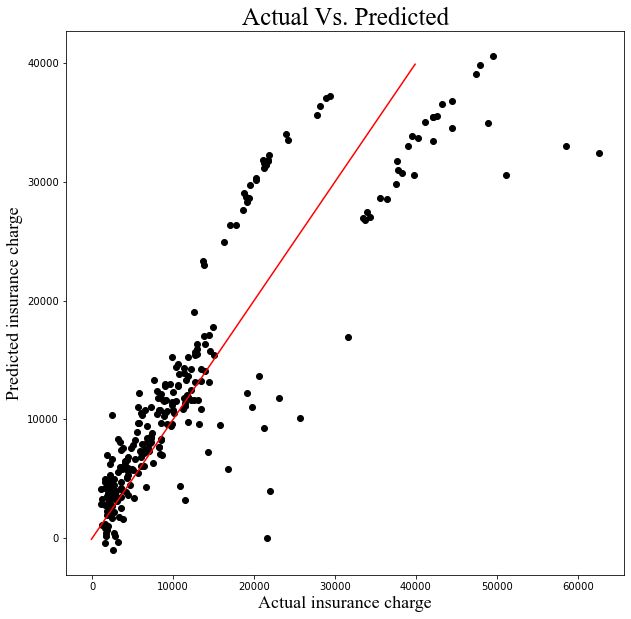

In [67]:
#plot y_test vs predicted_y
plt.subplots(figsize=(10,10))
plt.scatter(y_test,predicted_y,color = 'black')
x_1 = range(-100,40000,100)
y_1 = range(-100,40000,100)
plt.plot(x_1,y_1,color='red')
plt.title('Actual Vs. Predicted',fontname = 'Times New Roman',fontsize=25)
plt.xlabel('Actual insurance charge',fontname = 'Times New Roman',fontsize=18)
plt.ylabel('Predicted insurance charge',fontname = 'Times New Roman',fontsize=18)

# Project Summary 

1. Goal: To develop an effective model to predict one's insurance charge by using his/her health data



2. Dataset: 
age, bmi, sex, number of children, region, smoker, charges are provided. (1338 rows x 7 columns)

  a. Predictors: age, bmi, sex, number of children, region, smoker 
  b. Response: charges



3. simple linear regression between each predictor and charges
  a. age and insurance charges 
   - strong positive correlation ($r^2$ $\approx$ 71%)
   - linear regression equation: $y = 264.83x + 2862$
   : We find that a 1 year increase is associated with an increase in charges by around $264.83 
  
  b. bmi and insurance charges  
   - weak positive correlation ($r^2$ $\approx$ 7.1%)
   - linear regression equation: $y = 370.11x + 1992$
   : BMI doesn't have a strong association with charges which is unexpected for me!
   
  c. sex and insurance charges 
   - near zero correlation ($r^2$ $\approx$ 0.3%)
   - linear regression equation: $y = -1387.17x + 13957$ (x being 0 for male 1 for female:binary variable)
   : the correlation is extremely small, but statistically significant (p <.05)
   
  d. children and insurance charges 
   - near zero correlation ($r^2$ $\approx$ 0.5%)
   - linear regression equation: $y = 683.09x + 12522$ (x being 0 for male 1 for female:binary variable)
   : simliar characteristic as the sex variable
  
  e. smoker and insurance charges
   - strong positive correlation after the age variable ($r^2$ $\approx$ 62%)
   - linear regression equation: $y = 23615.96x + 8434$ (x being 0 for non-smoker 1 for smoker:binary variable)
   : As expected, the effect of whether or not smoking (the coefficent = 23615.96) is huge. On average, if you are a smoker, you are paying $23615.96 more than non-smokers in insurance charege. What a waste! plus high price of cigaretts..<br>
   
   
   
4. Building a model: Multiple Linear Regression 
  a. All of the predictors were used because they are statistical significant and none of them have high correlations to each other (no multicollinearity)
  b. The multiple linear regression
  
  $256.94 * age + 253.53* sex      + 337.67* bmi     + 552.84* children     + 23660.10*smoker - 845.43* southeast     + 56.31* northwest - 845.70* southwest - 12245.75$
  
  c. $r^2$ is 77.8%. The model is fairly effective 